In [1]:
import pathlib
import datetime

import pint
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import ee
import geojson

ureg = pint.UnitRegistry()

# Hycom
This data is based on the Hybrid Coordinate Ocean Model (HYCOM). The sea surface elevation anomalies are relative to the modeled elevation mean. The data up to 2018 is based on  daily timesteps. The latest  data  is based on 3  hour timesteps. Tide is not included in this model. Wind is, but it is  filtered so that it does not include storm surge. See [Cummings2013](https://link.springer.com/chapter/10.1007/978-3-642-35088-7_13) for  details. 

We'll process this dataset into two timeseries, monthly and annual. We compute the mean value for the coastline geometry. 

In [2]:
ee.Initialize()

# load the geometry for the  coastline
coastline_path = pathlib.Path('~/src/sealevel/data/deltares/coastline.geojson').expanduser()
cs_outer_path = pathlib.Path('~/src/sealevel/data/deltares/outside-continental-shelf.geojson').expanduser()

# geometry  with a coastline
with coastline_path.open() as f:
    coastline = geojson.load(f)
# geometry of outer continental shelf
with cs_outer_path.open() as f:
    cs_outer = geojson.load(f)   
hycom = ee.ImageCollection("HYCOM/sea_surface_elevation")
# values should be  multiplied  with this scale
scale = 0.001 

In [3]:
def coastline_mean(i):
    value = i.reduceRegion(ee.Reducer.mean(), coastline)
    return i.set(value)

hycom_timeseries =  hycom.map(coastline_mean)
ssh = [x * scale for x in  hycom_timeseries.aggregate_array('surface_elevation').getInfo()]
times = hycom_timeseries.aggregate_array('system:time_start').getInfo()
dates = [datetime.datetime.fromtimestamp(t / 1000) for t in times]

In [4]:
df = pd.DataFrame(dict(date=dates, ssh=ssh))
df.set_index('date').groupby(pd.Grouper(freq='YS'))
year_series = df.set_index('date').groupby(pd.Grouper(freq='YS')).agg(['mean', 'count'])
df.tail()

,date,ssh
13890,2020-03-21 22:00:00,-0.906964
13891,2020-03-22 01:00:00,-0.889517
13892,2020-03-22 04:00:00,-0.872164
13893,2020-03-22 07:00:00,-0.856583
13894,2020-03-22 10:00:00,-0.824237


In [5]:
year_result = year_series.ssh.reset_index()
# filter out years that are not completely filled
# year_result = year_result.query('date >= 1993 and date < 2020')
year_result = year_result.rename(columns={'mean': 'sea_surface_height'})
year_result.head()

,date,sea_surface_height,count
0,1992-01-01,-0.304746,91
1,1993-01-01,-0.364691,364
2,1994-01-01,-0.351791,364
3,1995-01-01,-0.338689,365
4,1996-01-01,-0.441779,332


In [6]:
month_series = df.set_index('date').groupby(pd.Grouper(freq="MS")).agg(['mean', 'count'])
month_result = month_series.ssh.reset_index()
month_result = month_result.rename(columns={'mean': 'sea_surface_height'})
# for  validation let's compute the year means from the monthly means
month_then_year_result = month_result.set_index('date').groupby(pd.Grouper(freq='YS')).agg('mean').reset_index()


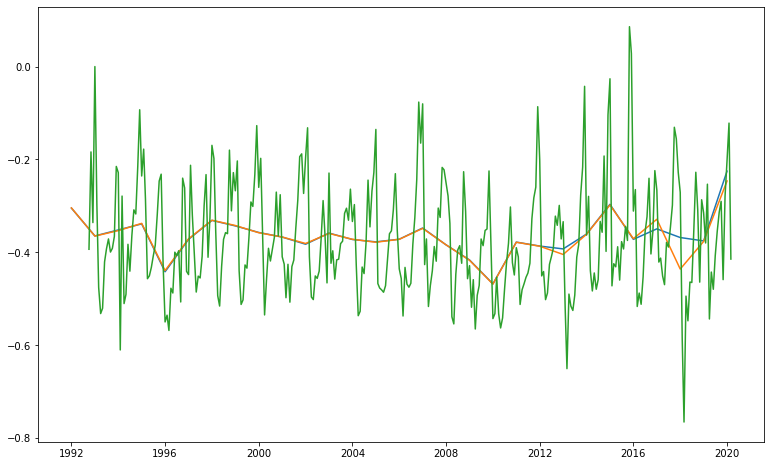

In [7]:
fig, ax =  plt.subplots(figsize=(13, 8))

ax.plot(year_result['date'], year_result['sea_surface_height'])
ax.plot(month_then_year_result['date'], month_then_year_result['sea_surface_height'] )

ax.plot(month_result['date'], month_result['sea_surface_height'])

# Density
Most of the changes in the in the hycom  model are due to  changes  in the  vertical. Because wind is  filtered

Wind in NEMO (barotrope als 1 laag), soort hycom van de EU.
Glossis dichtheid  constant ->
Klimaatsommen -> mean sea-level drukken we op als een tijdsafhankelijke drukformulering (in recente sommen).
Glossis parameters gecallibreerd vooraf, tijdens de berekening geen assimilatie.

Grace: zelfde massa meer volume. Wat als de oceaan een meter uitzet.   

In [8]:
def vertical_mean_density(i):
    """compute the mean density over the vertical"""
    # TODO: check  if this  mean is  representative
    result = (i
        .resample('bicubic')
        .reduce(ee.Reducer.mean())
        .set('system:time_start',  i.date().millis())
    )
    return result
density = ee.ImageCollection("users/fbaart/metoffice/density_en4")
mean_density = mean_density = density.map(vertical_mean_density)
def spatial_mean(i):
    scale = 10000
    result = i.reduceRegion(ee.Reducer.mean(), cs_outer, scale)
    return i.set(result)

series = mean_density.map(spatial_mean)


In [9]:
density_series = series.aggregate_array('mean').getInfo()
times = series.aggregate_array('system:time_start').getInfo()
dates = [datetime.datetime.fromtimestamp(t / 1000) for t in times]

density_df = pd.DataFrame(dict(date=dates, density=density_series))

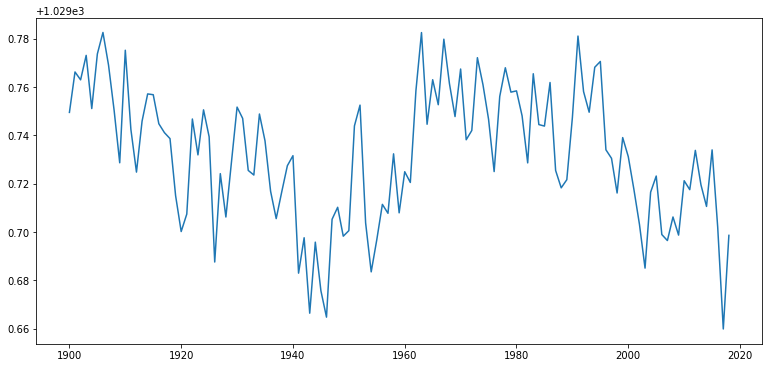

In [29]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(density_df.date, density_df.density)

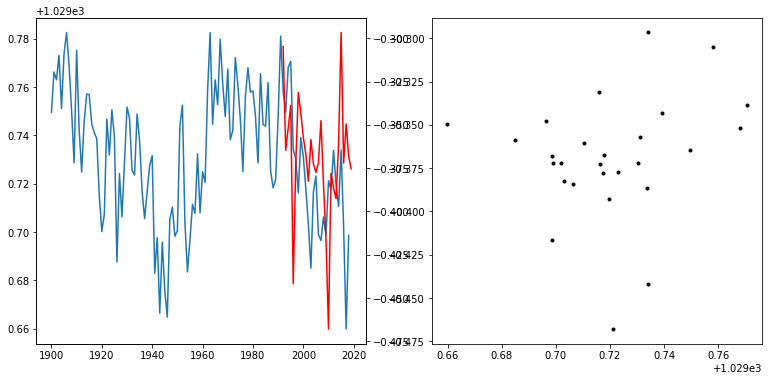

In [27]:
fig, axes = plt.subplots(figsize=(13, 6), ncols=2)
axes[0].plot(density_df.date, density_df.density)
ax2 = axes[0].twinx()
selected = year_result.query('date < datetime.datetime(2020,  1,  1)')
ax2.plot(selected['date'], selected['sea_surface_height'], color='red')

left = density_df.set_index('date').groupby(pd.Grouper(freq='YS')).agg('mean')
right = selected.set_index('date')
merged_df = pd.merge(left, right, left_index=True, right_index=True)
axes[1].plot(merged_df.density, merged_df.sea_surface_height, 'k.')